<a href="https://colab.research.google.com/github/BrandonKTC/Statistic_python/blob/main/Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory, Libraries  and Data

In [2]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Facebook Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Facebook Prophet


In [4]:
# import Libraries
import pandas as pd
import numpy as np
from prophet import Prophet

In [14]:
# get the data
df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


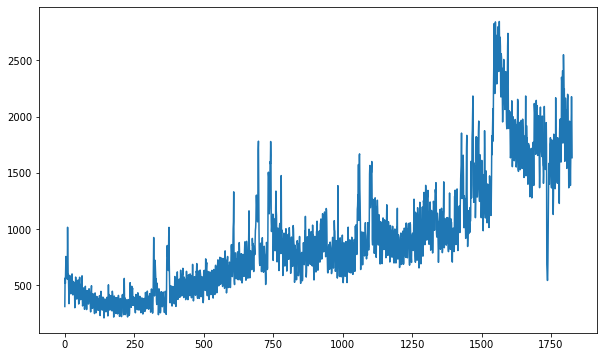

In [7]:
# plot

df.Udemy.plot(figsize=(10, 6))

# Data Preparation

In [15]:
# Date Variable
df.Date = pd.to_datetime(df.Date,
                         format="%m/%d/%Y")
df.head(2).Date

0   2016-01-01
1   2016-01-02
Name: Date, dtype: datetime64[ns]

In [17]:
# Renaming Variables
df = df.rename(columns={'Date': 'ds',
                'Udemy': 'y'})
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


# Dynamic Holidays

In [18]:
# Easter
easter_dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': "easter",
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


In [20]:
# Black Friday
bf_dates = pd.to_datetime(df[df["Black Friday"] == 1].ds)
bf_dates = pd.DataFrame({'holiday': 'black_friday',
                         'ds': bf_dates,
                         'lower_window': -7,
                         'upper_window': 5})
bf_dates

,holiday,ds,lower_window,upper_window
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [21]:
# Combine events
holidays = pd.concat([easter, bf_dates])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [22]:
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [23]:
# Remove events fro mmain dataframe
df.drop(["Easter", "Black Friday"], axis=1, inplace=True)
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


# Facebook Prophet

In [25]:
# Training and test split
test_days = 31

training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]

len(training_set), len(test_set)

(1796, 31)

In [27]:
# Facebook Prophet model
m = Prophet(growth="linear",
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            seasonality_mode="multiplicative",
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor('Christmas')
m.fit(training_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/459mr0d2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/cj6_u3ue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97884', 'data', 'file=/tmp/tmpnftxzfww/459mr0d2.json', 'init=/tmp/tmpnftxzfww/cj6_u3ue.json', 'output', 'file=/tmp/tmpdxahzxrc/prophet_model-20220822065705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
# Coefficient Regressor
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.295902,-0.295902,-0.295902


# Accuracy assesment

In [31]:
# Create future dataframe
future = m.make_future_dataframe(periods=test_days,
                                 freq="D")
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future.head(2)

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0


In [32]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,black_friday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,431.380287,255.401659,644.594576,431.380287,431.380287,0.0,0.0,0.0,0.0,...,-0.023165,-0.023165,-0.023165,0.080616,0.080616,0.080616,0.0,0.0,0.0,456.163574
1,2016-01-02,430.638340,192.095380,608.271832,430.638340,430.638340,0.0,0.0,0.0,0.0,...,-0.177926,-0.177926,-0.177926,0.106371,0.106371,0.106371,0.0,0.0,0.0,399.824062
2,2016-01-03,429.896393,224.792018,612.728359,429.896393,429.896393,0.0,0.0,0.0,0.0,...,-0.140568,-0.140568,-0.140568,0.131266,0.131266,0.131266,0.0,0.0,0.0,425.897413
3,2016-01-04,429.154445,341.137604,729.636058,429.154445,429.154445,0.0,0.0,0.0,0.0,...,0.077109,0.077109,0.077109,0.154895,0.154895,0.154895,0.0,0.0,0.0,528.720363
4,2016-01-05,428.412498,350.586641,747.623132,428.412498,428.412498,0.0,0.0,0.0,0.0,...,0.098600,0.098600,0.098600,0.176873,0.176873,0.176873,0.0,0.0,0.0,546.428456


In [37]:
# Retrieve predictions
preds = forecast.yhat[-test_days:]
preds[:2]

1796    3046.160338
1797    2824.841103
Name: yhat, dtype: float64

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_set['y'], preds)
mse = np.sqrt(mean_squared_error(test_set['y'], preds))

print("MAE", mae)
print("RMSE", mse)

MAE 221.56222375197314
RMSE 305.43990559929097


# Visualization

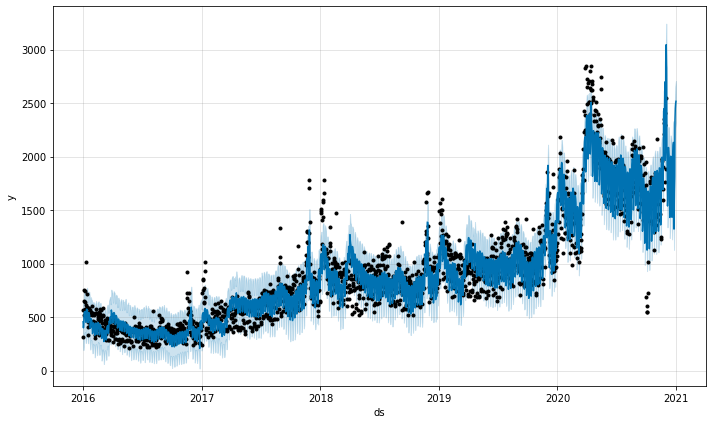

In [40]:
# forecast
m.plot(forecast);

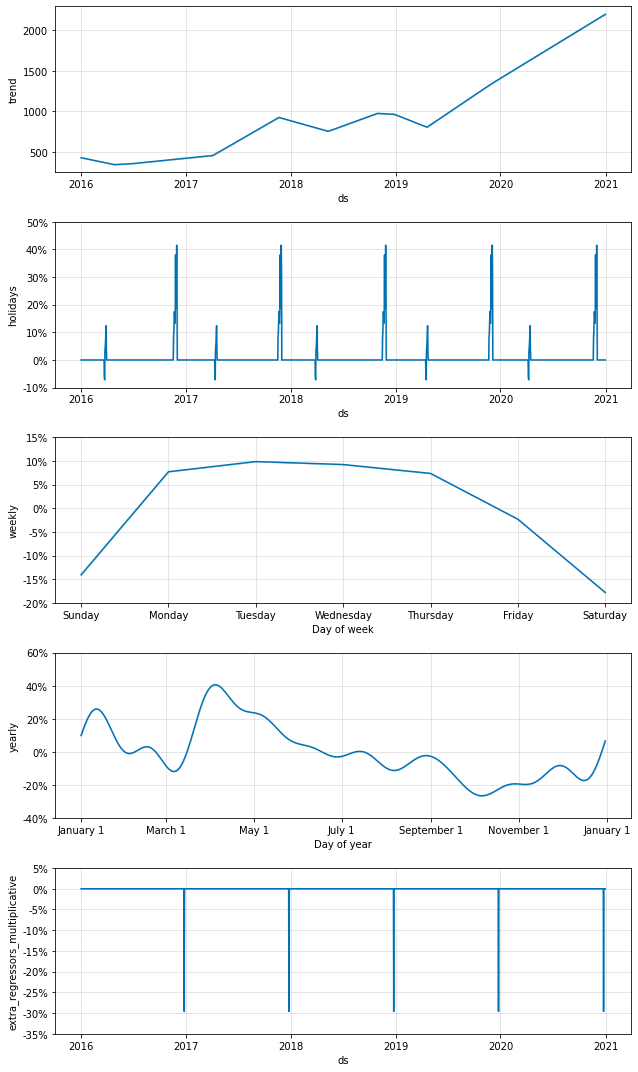

In [41]:
# ploot components
m.plot_components(forecast);

# Cross-validation

In [42]:
#CV
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model=m,
                         horizon="31 days",
                         initial="1500 days",
                         parallel="processes")
df_cv.head()

INFO:prophet:Making 18 forecasts with cutoffs between 2020-02-09 12:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc529402a90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/w1rx4696.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/qvftls_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/132e9c5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83466', 'data', 'file=/tmp/tmpnftxzfww/w1rx4696.json', 'init=/tmp/tmpnftxzfww/132e9c5w.json', 'output', 'file=/tmp/tmpj3pui2wi/prophet_model-20220822073324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnftxzfww/ghye7m_b.json
07:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEB

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-10,1416.676986,1283.050375,1547.854983,1611,2020-02-09 12:00:00
1,2020-02-11,1464.747830,1337.991406,1598.403146,1528,2020-02-09 12:00:00
2,2020-02-12,1462.819663,1325.320557,1595.270390,1365,2020-02-09 12:00:00
3,2020-02-13,1432.914343,1307.418863,1572.192303,1487,2020-02-09 12:00:00
4,2020-02-14,1298.067363,1167.587047,1436.388956,1265,2020-02-09 12:00:00


In [43]:
# Measure the error

mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

print("MAE", mae)
print("RMSE", mse)

MAE 379.169862657693
RMSE 529.5204839154572


# Parameter Tuning

In [44]:
# Grid
from sklearn.model_selection import ParameterGrid

param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}

grid = ParameterGrid(param_grid)

In [ ]:
# Hyperparameter
rmse = []

# Parameter tuning loop
for params in grid:

  #model
  m = Prophet(growth='linear',
              yearly_seasonality=True,
              weekly_seasonality=True,
              daily_seasonality=False,
              seasonality_mode='multiplicative',
              seasonality_prior_scale=params['seasonality_prior_scale'],
              holidays_prior_scale=params['holidays_prior_scale'],
              changepoint_prior_scale=params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.fit(training_set)
  # cross_validation
  df_cv = cross_validation(m,
                           horizon="31 days",
                           initial="1500 days",
                           parallel="processes")
  # store the results
  rmse.append(np.sqrt(mean_squared_error(df_cv["y"], df_cv["yhat"])))

In [47]:
best_params = grid[np.argmin(rmse)]
best_params

{'seasonality_prior_scale': 5,
 'holidays_prior_scale': 10,
 'changepoint_prior_scale': 0.1}